Notebook is adapted from 
1. https://huggingface.co/blog/time-series-transformers 
2. https://github.com/huggingface/notebooks/blob/main/examples/time_series_datasets.ipynb

# Time Series Datasets

This notebook shows how to create a time series dataset from some csv file in order to then share it on the [🤗 hub](https://huggingface.co/docs/datasets/index). We will use the GluonTS library to read the csv into the appropriate format. We start by installing the libraries

In [1]:
! pip install -q datasets gluonts orjson evaluate accelerate ujson transformers==4.31.0  

GluonTS comes with a pandas DataFrame based dataset so our strategy will be to read the csv file, and process it as a `PandasDataset`. We will then iterate over it and convert it to a 🤗 dataset with the appropriate schema for time series. So lets get started!

## `PandasDataset`

Suppose we are given multiple (10) time series stacked on top of each other in a dataframe with an `item_id` column that distinguishes different series:

In [ ]:
import sys

sys.path.append("../")

import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.utils import *

In [3]:
data_path = "../data/"


data = pd.read_csv(f"{data_path}data_all_radians.csv")
data["joystickX"] = -1 * data["joystickX"]

proficiencies = pd.read_csv(f"{data_path}overall_proficiency.csv")

training_parameters = None

config_path = "../configs/training/pilot_mars_informer_good_small_window_future.json"

with open(config_path, "r") as f:
    config_json = json.load(f)
    training_parameters = config_json["dl_training_parameters"]


ppts, ppt_data = filter_data_based_proficiency(
    data, proficiencies, proficiency=training_parameters["proficiency"]
)


# train_data, test_data = train_test_split_trials(ppt_data, ppts, train=training_parameters['train_fraction'])

In [4]:
# created toy dataset for checking if it works

ppt_data = ppt_data[
    ppt_data["peopleTrialKey"].isin(list(ppt_data.peopleTrialKey.unique())[:2])
]

In [5]:
len(ppt_data.peopleTrialKey.unique())

2

In [6]:
rolling_window_size = 5  # 100ms
window_size = 15  # 500ms
prediction_length = 5  # 200ms

In [7]:
train_df = process_timeseries(
    ppt_data, rolling_window_size, window_size, prediction_length, train=True
)
test_df = process_timeseries(
    ppt_data, rolling_window_size, window_size, prediction_length, train=False
)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


In [8]:
len(train_df.peopleTrialKey_window_num.unique()), len(
    test_df.peopleTrialKey_window_num.unique()
)

(1890, 1888)

In [9]:
train_df = train_df[
    train_df.peopleTrialKey_window_num.isin(test_df.peopleTrialKey_window_num)
]

After converting it into a `pd.Dataframe` we can then convert it into GluonTS's `PandasDataset`:

In [10]:
len(train_df.peopleTrialKey_window_num.unique()), len(
    test_df.peopleTrialKey_window_num.unique()
)

(1888, 1888)

In [11]:
# test_df = test_df[test_df.peopleTrialKey_window_num == test_df.peopleTrialKey_window_num.unique()[0]]

In [12]:
test_df

,seconds,trialPhase,currentPosRollRadians,currentVelRollRadians,joystickX,peopleName,peopleTrialKey,peopleTrialKey_window_num
0,1.279,3,0.014285,0.0,0.000031,2_mc_P18,2_mc_P18/12_600back_Block3_trial_012.csv,2_mc_P18/12_600back_Block3_trial_012.csv_0
1,1.299,3,0.013183,0.0,0.000031,2_mc_P18,2_mc_P18/12_600back_Block3_trial_012.csv,2_mc_P18/12_600back_Block3_trial_012.csv_0
2,1.321,3,0.012032,-0.008988,0.000031,2_mc_P18,2_mc_P18/12_600back_Block3_trial_012.csv,2_mc_P18/12_600back_Block3_trial_012.csv_0
3,1.341,3,0.01093,-0.008988,0.000031,2_mc_P18,2_mc_P18/12_600back_Block3_trial_012.csv,2_mc_P18/12_600back_Block3_trial_012.csv_0
4,1.361,3,0.010067,-0.008988,0.000031,2_mc_P18,2_mc_P18/12_600back_Block3_trial_012.csv,2_mc_P18/12_600back_Block3_trial_012.csv_0
...,...,...,...,...,...,...,...,...
15,101.002,3,0.018024,-0.008988,-0.0,2_mc_P18,2_mc_P18/20_600back_Block5_trial_020.csv,2_mc_P18/20_600back_Block5_trial_020.csv_942
16,101.021,3,0.017833,-0.008988,-0.0,2_mc_P18,2_mc_P18/20_600back_Block5_trial_020.csv,2_mc_P18/20_600back_Block5_trial_020.csv_942
17,101.041,3,0.017689,-0.008988,-0.0,2_mc_P18,2_mc_P18/20_600back_Block5_trial_020.csv,2_mc_P18/20_600back_Block5_trial_020.csv_942
18,101.063,3,0.017545,-0.008988,-0.0,2_mc_P18,2_mc_P18/20_600back_Block5_trial_020.csv,2_mc_P18/20_600back_Block5_trial_020.csv_942


In [13]:
from gluonts.dataset.pandas import PandasDataset


train_ds = PandasDataset.from_long_dataframe(
    train_df,
    target="joystickX",
    item_id="peopleTrialKey_window_num",
    timestamp="seconds",
    feat_dynamic_real=["currentPosRollRadians", "currentVelRollRadians"],
    freq="ms",
    unchecked=True,
)

test_ds = PandasDataset.from_long_dataframe(
    test_df,
    target="joystickX",
    item_id="peopleTrialKey_window_num",
    timestamp="seconds",
    feat_dynamic_real=["currentPosRollRadians", "currentVelRollRadians"],
    freq="ms",
    unchecked=True,
)

In [14]:
train_ds, test_ds

(PandasDataset<size=1888, freq=ms, num_feat_dynamic_real=2, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>,
 PandasDataset<size=1888, freq=ms, num_feat_dynamic_real=2, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>)


## 🤗 Datasets

From here we have to map the pandas dataset's `start` field into a time stamp instead of a `pd.Period`. We do this by defining the following class:

In [15]:
class ProcessStartField:
    ts_id = 0

    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        self.ts_id += 1

        return data

In [16]:
from gluonts.itertools import Map

process_start = ProcessStartField()

list_train_ds = list(Map(process_start, train_ds))
list_test_ds = list(Map(process_start, test_ds))

Next we need to define our schema features and create our dataset from this list via the `from_list` function:

In [17]:
from datasets import Dataset, Features, Value, Sequence

features = Features(
    {
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float64")),
        "feat_dynamic_real": Sequence(Sequence(Value("float32"))),
        # "past_feat_dynamic_real": Sequence(Sequence(Value("float32"))),
        "item_id": Value("string"),
    }
)

In [18]:
train_dataset = Dataset.from_list(list_train_ds, features=features)
test_dataset = Dataset.from_list(list_test_ds, features=features)

In [19]:
train_example = train_dataset[0]
test_example = test_dataset[0]

len(train_example["target"]), len(test_example["target"])

(15, 20)

In [20]:
test_example

{'start': datetime.datetime(1970, 1, 1, 0, 0),
 'target': [3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05,
  3.099999958067201e-05],
 'item_id': '2_mc_P18/12_600back_Block3_trial_012.csv_0',
 'feat_dynamic_real': [[0.014285196550190449,
   0.01318264752626419,
   0.012032161466777325,
   0.010929613374173641,
   0.010066748596727848,
   0.009251821786165237,
   0.00848483107984066,
   0.007765777874737978,
   0.0070946612395346165,
   0.0065194182097911835,
   0.006040049251168966,
   0.005512743256986141,
   0.004985437728464603,
   0.00441019469872117,
   0.003978762

We can thus use this strategy to [share](https://huggingface.co/docs/datasets/share) the dataset to the hub.

## Training Informer from scratch. 

In [21]:
from functools import lru_cache

import pandas as pd
import numpy as np

freq = "S"


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [22]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [23]:
from gluonts.time_feature import get_lags_for_frequency


lags_sequence = get_lags_for_frequency(freq)
lags_sequence = get_lags_for_frequency(freq, lag_ub=30)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7]


In [24]:
from gluonts.time_feature import time_features_from_frequency_str

# time_features = time_features_from_frequency_str(freq)
time_features = []
print(time_features)

[]


In [25]:
for k, v in test_dataset[0].items():
    try:
        print(k, type(v), len(v))
    except:
        pass

target <class 'list'> 20
item_id <class 'str'> 42
feat_dynamic_real <class 'list'> 2
feat_static_cat <class 'list'> 1


In [26]:
from transformers import InformerConfig, InformerForPrediction


config = InformerConfig(
    prediction_length=prediction_length,
    # # context length:
    context_length=prediction_length * 2,
    # input_size = 3,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset) * 1000],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[8],
    # The number of dynamic real valued features.
    # num_dynamic_real_features=len(train_dataset[0]['feat_dynamic_real']),
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = InformerForPrediction(config)

In [27]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from gluonts.transform.sampler import PredictionSplitSampler

In [28]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=[],
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [29]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [30]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [31]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [32]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=64,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [33]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([64, 17, 1]) torch.FloatTensor
past_values torch.Size([64, 17]) torch.FloatTensor
past_observed_mask torch.Size([64, 17]) torch.FloatTensor
future_time_features torch.Size([64, 5, 1]) torch.FloatTensor
static_categorical_features torch.Size([64, 1]) torch.LongTensor
future_values torch.Size([64, 5]) torch.FloatTensor
future_observed_mask torch.Size([64, 5]) torch.FloatTensor


In [34]:
# batch = next(iter(test_dataloader))
# for k, v in batch.items():
#     print(k, v.shape, v.type())

# Getting an error here

In [35]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"].type(torch.FloatTensor),
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"].type(torch.FloatTensor),
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [36]:
print("Loss:", outputs.loss.item())

Loss: -2.917275905609131


Note that the model is returning a loss. This is possible as the decoder automatically shifts the `future_values` one position to the right in order to have the labels. This allows computing a loss between the predicted values and the labels.

Also note that the decoder uses a causal mask to not look into the future as the values it needs to predict are in the `future_values` tensor.

## Train the Model

It's time to train the model! We'll use a standard PyTorch training loop.

We will use the 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) library here, which automatically places the model, optimizer and dataloader on the appropriate `device`.

In [37]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator(cpu=True)
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

epochs = 10

model.train()

losses = []

for epoch in tqdm(range(epochs)):
    batch_losses = []
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"]
            .type(torch.FloatTensor)
            .to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"]
            .type(torch.FloatTensor)
            .to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        batch_losses.append(loss.item())

    losses.append(sum(batch_losses) / len(batch_losses))
    # if idx % 1000 == 0:
    #     print(loss.item())

100%|██████████| 10/10 [01:20<00:00,  8.10s/it]


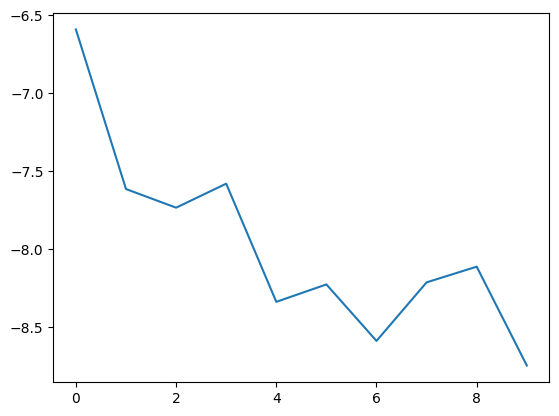

In [38]:
try:
    plt.plot(losses)
    plt.show()
except:
    print("error while plotting losses")

In [164]:
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(
    f"./output/Informer-Transformer-roll-{rolling_window_size}-window-{window_size}-future-{prediction_length}-v3/",
    is_main_process=accelerator.is_main_process,
    save_function=accelerator.save,
)

In [165]:
model = InformerForPrediction.from_pretrained(
    f"./output/Informer-Transformer-roll-{rolling_window_size}-window-{window_size}-future-{prediction_length}-v3/"
)

model

InformerForPrediction(
  (model): InformerModel(
    (scaler): InformerMeanScaler()
    (embedder): InformerFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(1888000, 8)
      )
    )
    (encoder): InformerEncoder(
      (value_embedding): InformerValueEmbedding(
        (value_projection): Linear(in_features=24, out_features=32, bias=False)
      )
      (embed_positions): InformerSinusoidalPositionalEmbedding(15, 32)
      (layers): ModuleList(
        (0-3): 4 x InformerEncoderLayer(
          (self_attn): InformerProbSparseAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation

In [166]:
model.config

InformerConfig {
  "_name_or_path": "./output/Informer-Transformer-roll-5-window-15-future-5-v3/",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "InformerForPrediction"
  ],
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    1888000
  ],
  "context_length": 10,
  "d_model": 32,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.05,
  "embedding_dimension": [
    8
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 4,
  "feature_size": 24,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 1,
  "num_s

## Inference

At inference time, it's recommended to use the `generate()` method for autoregressive generation, similar to NLP models.

Forecasting involves getting data from the test instance sampler, which will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model. Note that we pass `future_time_features`, which are known ahead of time, to the decoder.

The model will autoregressively sample a certain number of values from the predicted distribution and pass them back to the decoder to return the prediction outputs:

In [39]:
model.eval()


device = torch.device("cpu")
forecasts = []
max_val = 0
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"]
        .type(torch.FloatTensor)
        .to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"]
        .type(torch.FloatTensor)
        .to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`).

In this case, we get `100` possible values for the next `24` months (for each example in the batch which is of size `64`):

In [40]:
len(test_dataset)

1888

In [41]:
forecasts[0].shape

(64, 100, 5)

We'll stack them vertically, to get forecasts for all time-series in the test dataset:

In [42]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(1888, 100, 5)


In [43]:
np.mean(forecasts, axis=1)[0]

array([2.8036377e-05, 2.6425849e-05, 2.2847471e-05, 2.0626860e-05,
       1.8671402e-05], dtype=float32)

We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) and [sMAPE](https://huggingface.co/spaces/evaluate-metric/smape) metrics.

We calculate both metrics for each time series in the dataset:

In [44]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)
mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    # mase = mase_metric.compute(
    #     predictions=forecast_median[item_id],
    #     references=np.array(ground_truth),
    #     training=np.array(training_data),
    #     periodicity=get_seasonality(freq),
    # )
    # mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [45]:
# print(f"MASE: {np.mean(mase_metrics)}")

In [46]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 1.1343674675483078


We can also plot the individual metrics of each time series in the dataset and observe that a handful of time series contribute a lot to the final test metric:

In [174]:
# plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
# plt.xlabel("MASE")
# plt.ylabel("sMAPE")
# plt.show()

To plot the prediction for any time series with respect the ground truth test data we define the following helper:

In [47]:
import matplotlib.dates as mdates


def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    # ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    # ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2 * prediction_length :],
        test_dataset[ts_index]["target"][-2 * prediction_length :],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.ylim((-1, +1))
    plt.legend()
    plt.show()

<Axes: xlabel='seconds'>

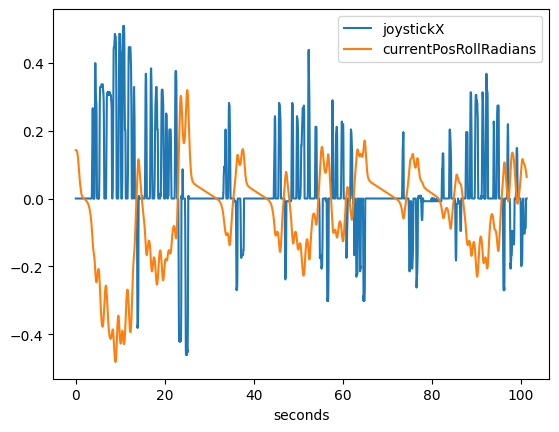

In [48]:
ppt_data[ppt_data.peopleTrialKey == ppt_data.peopleTrialKey.unique()[0]].plot(
    "seconds", ["joystickX", "currentPosRollRadians"]
)

For example:

In [ ]:
for i in range(200):
    plot(i)